# Вариант 3. Контроль количества параметров

Цель: Создание компактной сети.

* Создайте архитектуру, используя не более 50 000 параметров
* Условие: Один слой должен быть 1x1 сверткой, чтобы уменьшить число каналов
* Эксперимент: Подсчитайте количество параметров каждого слоя и убедитесь, что общая сумма не превышает лимита.


Возьмём такую архитектуру:  
* Изображение: 32x32  
* Conv: 3 -> 16, 3x3  
* Conv: 16 -> 32, 3x3  
* Conv: 32 -> 16, 1x1  
* AvgPool 2x2  
* FC: 4096 -> 10  

Формула для вычисления числа параметров в свёрточном слое: `out_channels × in_channels × kernel_h × kernel_w + out_channels`. Значит:
в conv1 448 параметров, в Conv2 - 4640, в свёртке с ядром 1 - 528, а в линейном слое - 40970. Итого: 46586

напишем класс с такой моделькой:

In [66]:
import torch
import torch.nn as nn

class Task1_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.reduce = nn.Conv2d(32, 16, kernel_size=1)

        self.pool = nn.AvgPool2d(kernel_size=2)

        self.fc = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.reduce(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


На всякий случай проверим число параметров:

In [56]:
def count_parameters(model):
    total = 0
    for name, param in model.named_parameters():
        num = param.numel()
        print(num)
        total += num
    return total


model = Task1_CNN()
count_parameters(model)

432
16
4608
32
512
16
40960
10


46586

ну и обучим на CIFAR чтобы проверить работает ли это вообще

In [72]:

import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.25, 0.25, 0.25))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Task1_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(epoch):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch}")


def test_epoch():
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test accuracy: {round(correct / total * 100, 3)}%")


for epoch in range(10):
    train_epoch(epoch)
    test_epoch()


Epoch 0
Test accuracy: 52.35%
Epoch 1
Test accuracy: 56.84%
Epoch 2
Test accuracy: 59.44%
Epoch 3
Test accuracy: 61.97%
Epoch 4
Test accuracy: 63.35%
Epoch 5
Test accuracy: 63.01%
Epoch 6
Test accuracy: 65.14%
Epoch 7
Test accuracy: 66.27%
Epoch 8
Test accuracy: 65.41%
Epoch 9
Test accuracy: 66.07%


# Вариант 5. Контроль градиентов через глубину

Цель: Изучение поведения градиентов в глубокой сети.

* Разработайте сеть с не менее 6 слоев, которая выводит тензор (batch, 64, 8, 8).
* Условие: Слои должны чередоваться между Conv2d и ReLU, при этом градиенты первого слоя должны быть меньше градиентов последнего после одной итерации backward() на случайных данных.
* Эксперимент: Визуализируйте градиенты по слоям и объясните, почему градиенты убывают или растут.


Если слои должны быть только conv и relu, тогда предположим, что исходное изображение было размером 8 на 8. Ну и получаем какую-то такую архитектуру:

In [73]:
class Task2_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 64, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        return x


Возьмём случайные x и y и посчитаем backward

In [83]:
from torch.optim import Adam

x_train = torch.randn(1, 3, 8, 8, requires_grad=True)
y_test = torch.randn(1, 64, 8, 8, requires_grad=True)

criterion = nn.CrossEntropyLoss()
model = Task2_CNN()
loss = criterion(model(x_train), y_test)

print("Loss:", loss.item())

loss.backward()

Loss: -7.331467151641846


<BarContainer object of 6 artists>

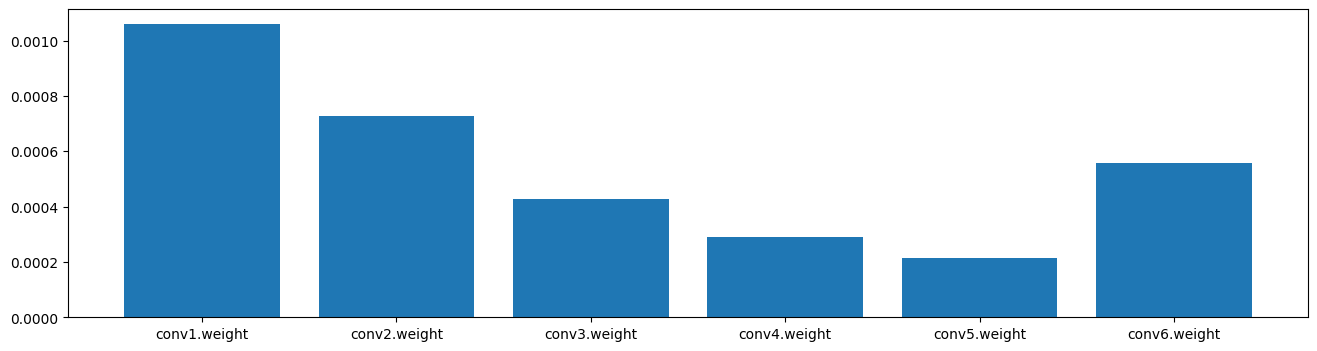

In [103]:
import matplotlib.pyplot as plt

grad_means = []
layer_names = []

names, grads = list(zip(*[(name, float(param.grad.abs().mean())) for name, param in model.named_parameters() if 'weight' in name]))

plt.figure(figsize=(16, 4))
plt.bar(names, grads)

Градиенты убывают на первых 5 слоях и возрастают на 6. Убывание скорее всего связано с тем, что relu зануляет часть значений и с тем, что начинает распределяться на увеличивающееся с каждым шагом количество весов. На 6 же шаге происходит резкое уменьшение числа весов, поэтому градиент "накапливается" и его значение заметно больше градиента на предыдущем слое. 